# Feature selection

Feature selection refers to algorithms that can help us narrow down our **feature set** to a smaller set of important features, where importance here refers to the strength of the relationship between the feature and the target. A more important feature is one that ultimately can influence the model's prediction more.

## Filter-based methods for feature selection

**Filter-based selection** refer to methods we can use to identify features with a high association and remove one as part of feature selection prior to machine learning. One way we can measure the degree to which two features are associated is using **correlation**, but correlation (**pearson's correlation coefficient**, to be specific) measures the strength of **linear association** meaning that when correlation is high between two features (close to 1 or -1) then their scatter plot looks like a straight line. If instead of a straight line the scatter plot followed a curved line, we need to use other measures such as **ranked correlation** or **mutual information**.

In the following example, we generate two features $X$ and $Y$ which are related to each other based on a polynomial (curve-like) equation with some added noise.

Standard Deviation of Y = 1.20


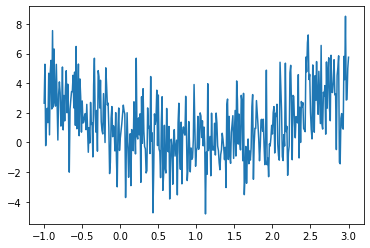

In [1]:
import numpy as np

X = np.linspace(start = -1, stop = 3, num = 401, endpoint = True)
Y = X**2 - 2*X + 1 # Y is a polynomial function of X
print("Standard Deviation of Y = {:0.2f}".format(np.std(Y)))

noise_var = 2
noise = np.random.normal(0, noise_var, len(X))
Y += noise # add noise

import matplotlib.pyplot as plt
plt.plot(X, Y)
plt.show()

Of course we can can just plot the features against each other and see how they're related, but imagine having to do this for every pair of some 20 features. So instead we want to rely on some metric to do this, so that we can later simply filter out redundant features based on the metric. Let's see what the correlation coefficient is.

In [2]:
corr = np.corrcoef(X, Y)[0, 1]
print("Correlation between X and Y is {:0.2f}".format(corr))

Correlation between X and Y is 0.05


As we can see, the correlation is close to zero, and if we had not plotted $X$ against $Y$, we would have been led to believe that there is no association between them, but let's now use mutual information to capture the stregth of their association.

In [3]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency = c_xy)
    return mi

print("Mutual information = {:0.2f}".format(calc_MI(X, Y, 20)))

Mutual information = 0.52


### Exercise

Return to the above example and increase the noise gradually (using `noise_var`) and see how it changes correlation and mutual information.

### End of exercise

## Wrapper methods for feature selection

The **embedded methods** for feature selection include **step-wise feature selection**, which is an iterative algorithm. It consists of this:

 - train a model with a set of features and evaluating its performance (accuracy)
 - see how much accuracy improves if we train a model but this time include a new and promising feature (this is called **forward selection**)
 - see how much accuracy goes down if we train a model but this time exclude an existing and not-so-useful feature (this is called **backward selection**)
 - repeat until model accuracy more-or-less peaks, leaving us with a **final model** whose selected features are a **subset** of all the features in the data (which is why step-wise selection is also called **best-subset selection**)

In other words, every step in stepwise regression is one where we either include a promising new feature that was left out so far, or exclude a feature that was part of the model so far but doesn't seem to contribute much to model performance. In this sense, step-wise selection, just like filter-based selection attemps to include new features that are bringing in **new information** and avoid features that are either just noise or redundant. The difference is that step-wise selection does this in an iterative and automated fashion. The downside is that step-wise regression can be slow, since every step requires that we train a new model so we can evaluate its performance.

Let's see how this works in action. We begin by generating a dataset using the `make_friedman1` function in `sklearn`. This function will intentially return a data with correlated features so that we can use it to do step-wise selection.

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_friedman1

X, y = make_friedman1(n_samples = 50, n_features = 10, random_state = 0)
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9
0,0.548814,0.715189,0.602763,0.544883,0.423655,0.645894,0.437587,0.891773,0.963663,0.383442
1,0.791725,0.528895,0.568045,0.925597,0.071036,0.087129,0.020218,0.832620,0.778157,0.870012
2,0.978618,0.799159,0.461479,0.780529,0.118274,0.639921,0.143353,0.944669,0.521848,0.414662
3,0.264556,0.774234,0.456150,0.568434,0.018790,0.617635,0.612096,0.616934,0.943748,0.681820
4,0.359508,0.437032,0.697631,0.060225,0.666767,0.670638,0.210383,0.128926,0.315428,0.363711


### Exercise

We can take a look at the correlation matrix to see which features are strongly correlated, but with 10 feature it's a lot of numbers to be sifting through. So one quick an easy way to do this is to create a heatmap from the correlation matrix. Find out how you can use the `seaborn` library to create a heatmap from the correlation matrix for the above data.

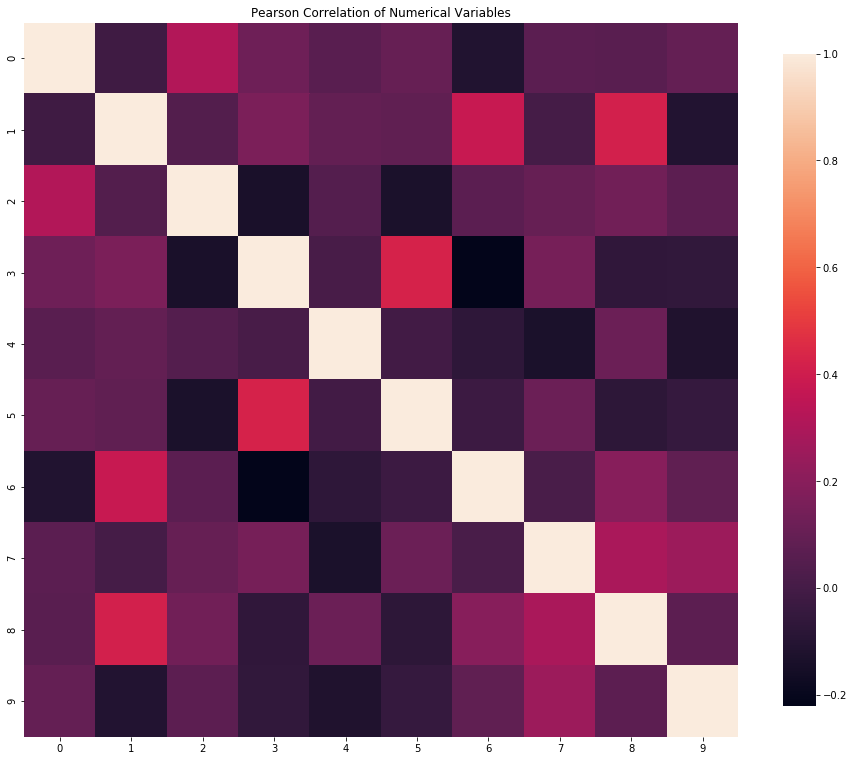

In [5]:
import seaborn as sns

_,ax=plt.subplots(figsize=(16,16))
plt.title('Pearson Correlation of Numerical Variables')
sns.heatmap(X.corr(),vmax=1.0,annot=False,square=True, cbar_kws={"shrink": .75});

### End of exercise!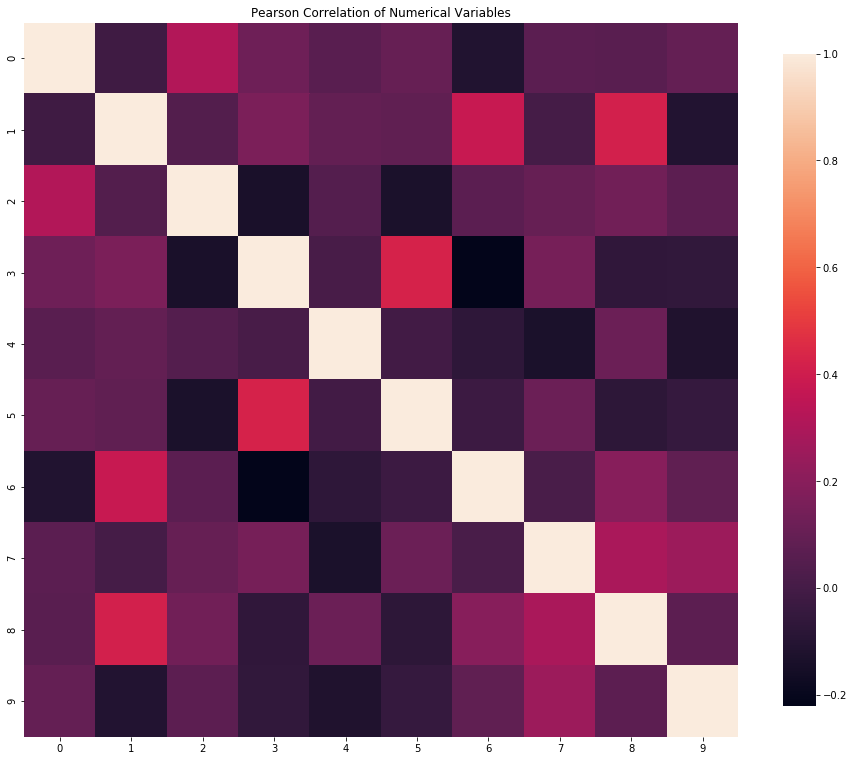

Time to try our hand at step-wise feature selection. First we choose the algorithm we want to use for training, which is `LinearRegression` in our case. Notice that in the code below we refer to the algorithm as an `estimator`. This is a common term used in machine learning. We then pass `estimator` to a step-wise selection algorithm called `RFE`, which stands for **recursive feature elimination** (another way of saying **backward selection**). So `RFE` acts as a **wrapper** for `LinearRegression`. To run it, we just call `fit` and pass it the data (just like we would have done with `estimator` itself), except that now `fit` runs the iterative backward selection algorithm we described above.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE 

estimator = LinearRegression()
back_selector = RFE(estimator, 5, step = 1, verbose = True) # select 5 features, removing 1 feature at a time
back_selector = back_selector.fit(X, y)

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.


We can see that the backward selection run started with 10 features, but ended with fewer, throwing out one feature at every step. We can see which features made the cut by running this:

In [9]:
print("The mask of selected features:")
print(back_selector.support_)

The mask of selected features:
[ True  True  True  True  True False False False False False]


We can see the order in which features were removed in the next cell, starting with the higher number. The features with rank 1 were the ones who made the cut (remained in the final model).

In [10]:
print("Ranking is the inverse of order of removal (higher rank is the first feature removed):")
print(back_selector.ranking_)

Ranking is the inverse of order of removal (higher rank is the first feature removed):
[1 1 1 1 1 2 3 6 5 4]


Because we ran `fit`, we can now run `predict` to get the final model's prediction.

In [11]:
yhat_backward = back_selector.predict(X)

For the sake of comparison, let's train the `estimator` (the original `LinearRegression` algorithm) on the whole data, without using backward selection and get predictions for it.

In [12]:
estimator = estimator.fit(X, y)
yhat_estimator = estimator.predict(X)

And now let's look at the correlation between (1) the labels and (2) the predictions when we do backward selection, and (3) the predictions when we don't do backward selection.

In [13]:
np.corrcoef([yhat_backward, yhat_estimator, y])

array([[1.        , 0.99038899, 0.88336559],
       [0.99038899, 1.        , 0.89193801],
       [0.88336559, 0.89193801, 1.        ]])

We should not be too surprised to see that the correlations are high, especially between the two predictions. 

### Exercise

There is one last sanity-check we can perform.

First create a subset of the data with only those features that made the cut in backward selection. HINT: You can use `back_selector.support_` to filter the features that `back_selector` ended up with. Name the data `X_subset`

In [14]:
X_subset = X.loc[:,back_selector.support_]
X_subset.head()

,0,1,2,3,4
0,0.548814,0.715189,0.602763,0.544883,0.423655
1,0.791725,0.528895,0.568045,0.925597,0.071036
2,0.978618,0.799159,0.461479,0.780529,0.118274
3,0.264556,0.774234,0.456150,0.568434,0.018790
4,0.359508,0.437032,0.697631,0.060225,0.666767


Now initialize a new estimator with `LinearRegression` and call it `estimator_subset`. Then train `estimator_subset`, on the `X_subset` and obtain predictions. 

In [15]:
estimator_subset = LinearRegression()
estimator_subset.fit(X_subset, y)
yhat_estimator = estimator_subset.predict(X_subset)

Finally, get the correlation matrix for (1) the label, (2) the predictions obtained by `estimator_subset` and (3) the predictions obtained by `back_selector`.

In [16]:
np.corrcoef([yhat_backward, yhat_estimator, y])

array([[1.        , 1.        , 0.88336559],
       [1.        , 1.        , 0.88336559],
       [0.88336559, 0.88336559, 1.        ]])

If you did it correctly, you should see a correlation of 1 between the two predictions, meaning the predictions are exactly the same. This is because backward selection returns a model trained on the subset of features that it deems the best, so manually training the model on that same subset should result in the same trained model.

### End of exercise

Instead of backward selection, we now try **forward selection**. Backward selection starts with all features and end with a subset, **dropping** a feature at each step. Forward selection starts with one feature and ends with a subset, **adding** a feature at each step. 

We can also do **step-wise selection** (using `SequentialFeatureSelector` in the `mlxtend` library), which starting with a subset of features, does **forward or backward** selection at each step, meaning that at each step it may choose to add a feature or drop a feature depending on which works better. 

In [17]:
!pip install mlxtend

In [18]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt

estimator = LinearRegression()

stepwise_selector = SFS(estimator, 
    k_features = "parsimonious", 
    forward = True, 
    floating = False, 
    scoring = 'neg_mean_squared_error', 
    cv = 10)

stepwise_selector = stepwise_selector.fit(X.values, y)

The `mlxtend` library gives us a plot for visualizing model performance as feature selection happens at each step.

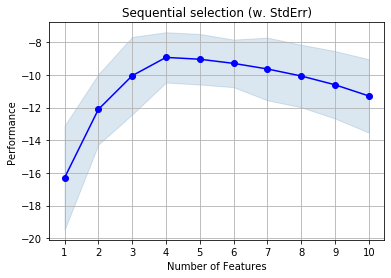

In [19]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(stepwise_selector.get_metric_dict(), kind = 'std_err')
plt.title('Sequential selection (w. StdErr)')
plt.grid()
plt.show()

### Exercise

So far we've been using an artificial dataset. Let's now switch to using a real dataset. We use the Boston housing dataset, which has information about houses in Boston and their sale price as a target.

In [20]:
from sklearn.datasets import load_boston

boston = load_boston()
X, y = boston.data, boston.target
X = pd.DataFrame(X, columns = boston.feature_names)
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Examine the data by reporting the number of rows, columns and plotting the scatter plot matrix.

In [21]:
X.shape

(506, 13)

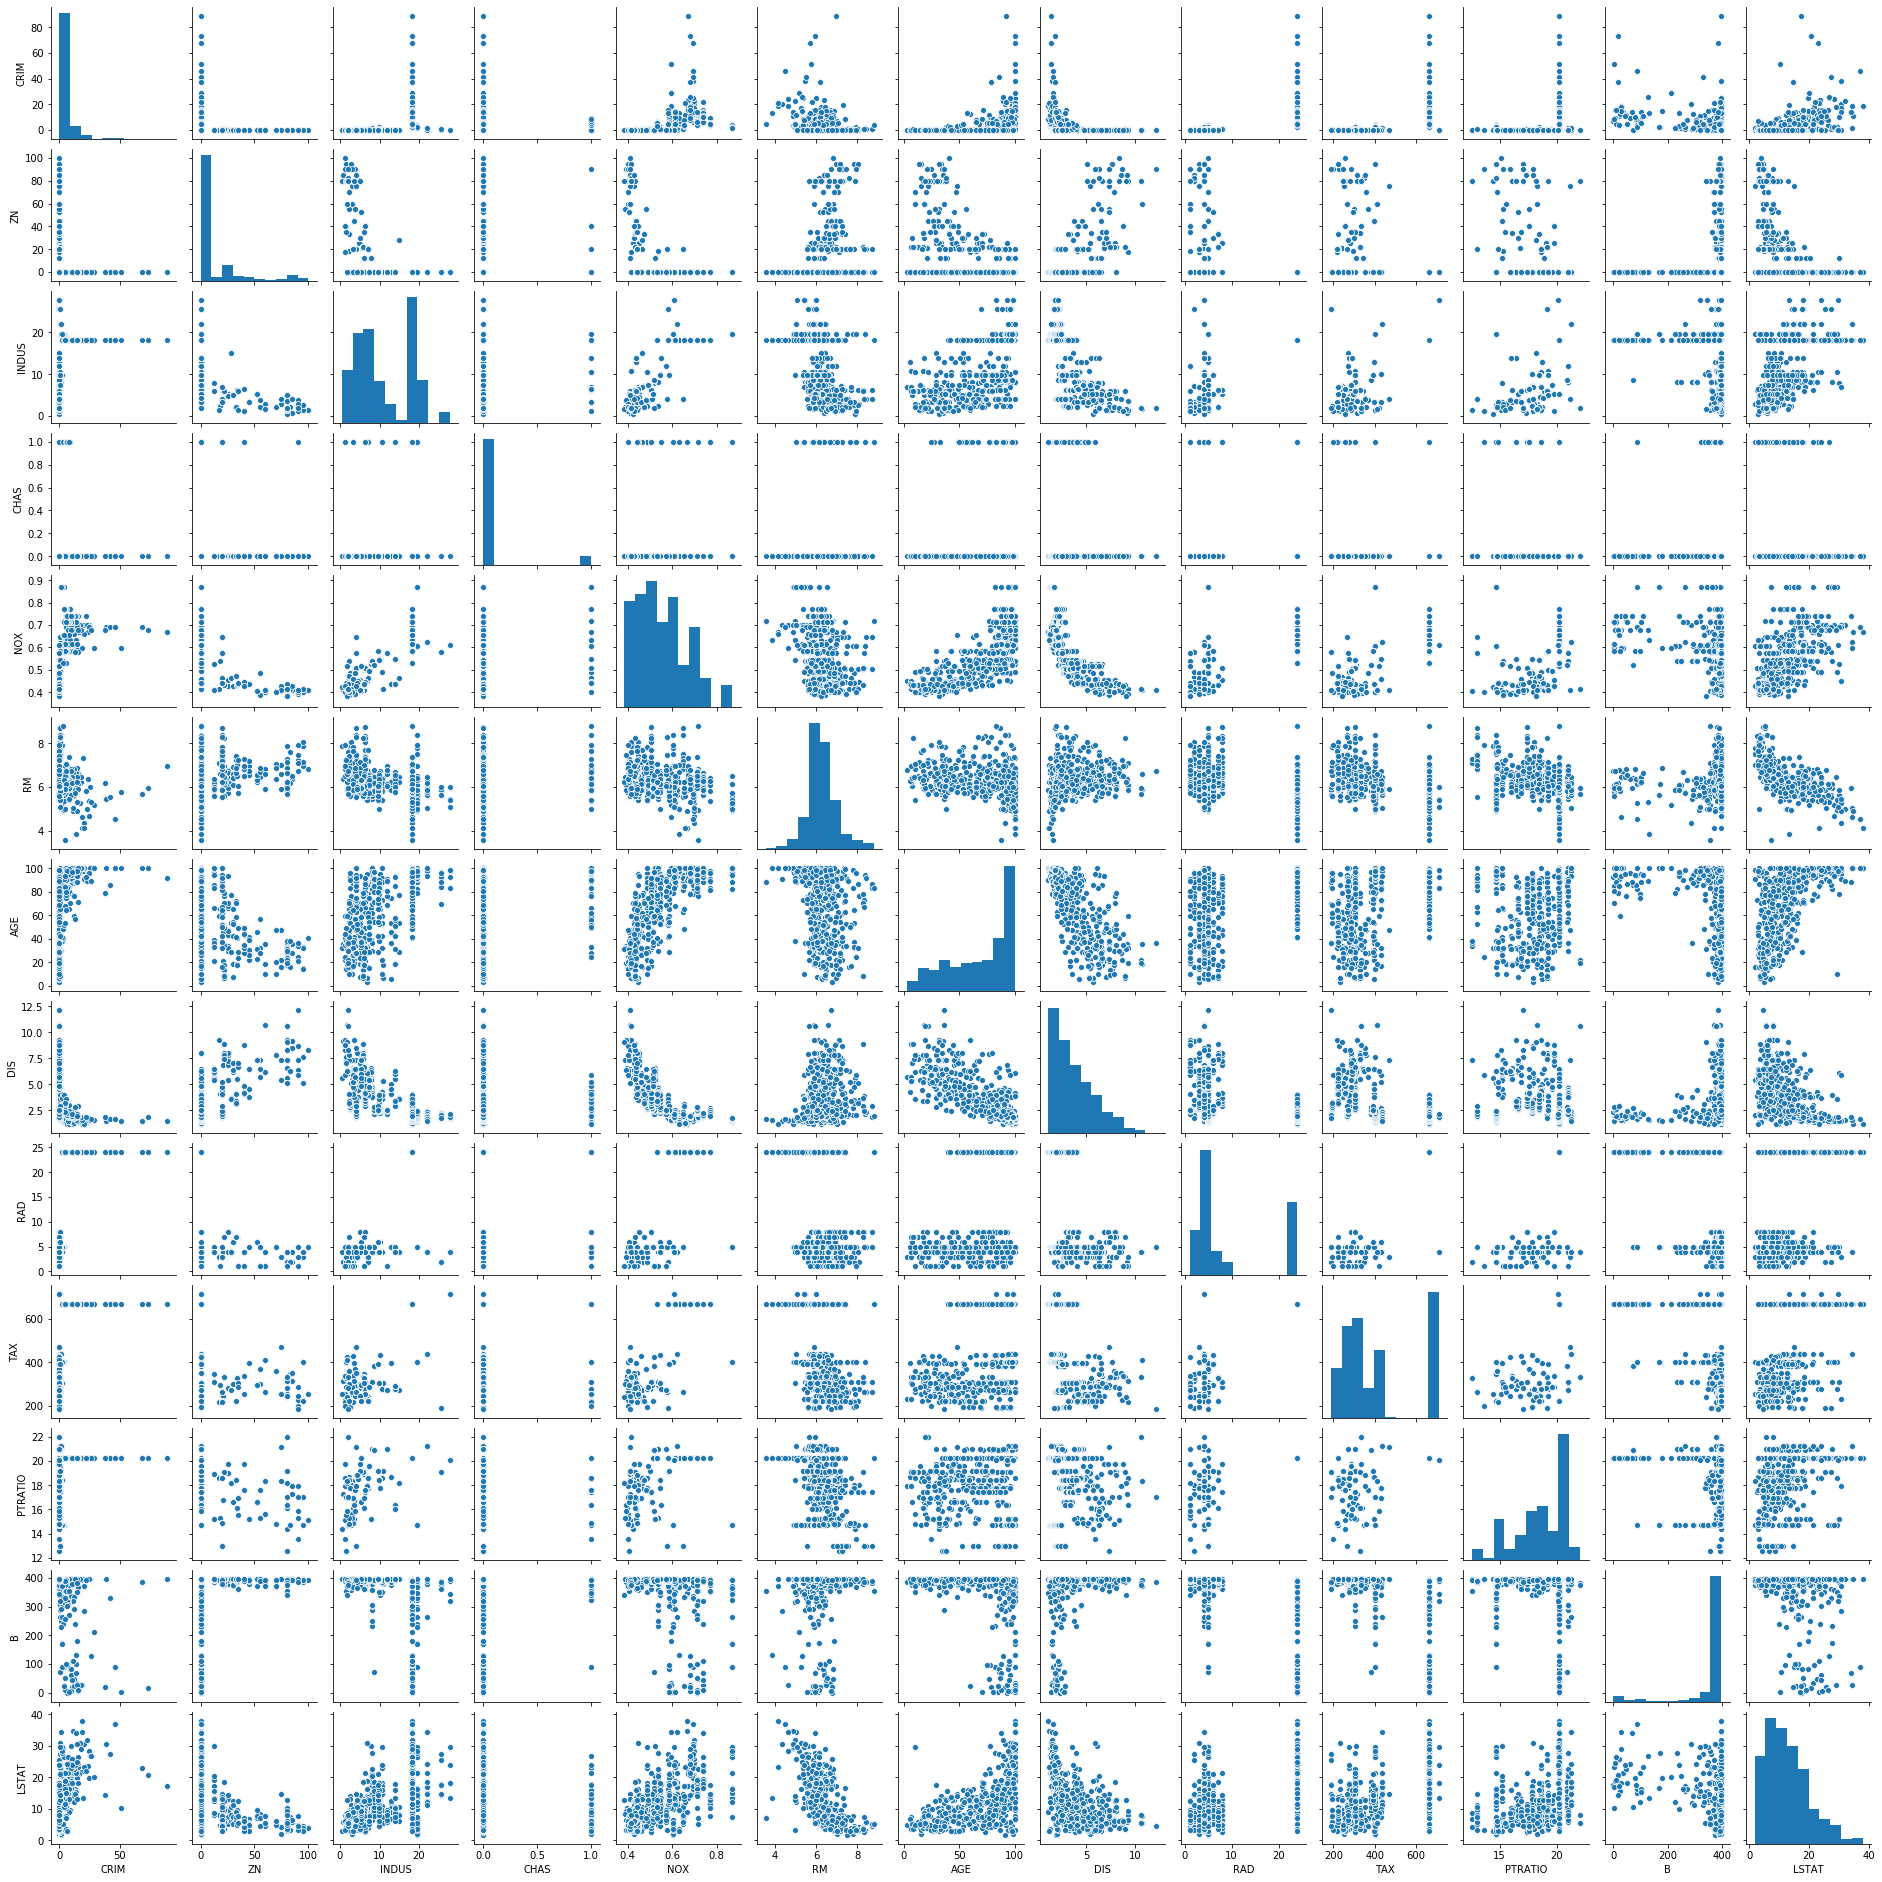

In [22]:
sns.pairplot(X, palette="seismic", height=2);

Similar to what we did previously, use `SFS` to train a step-wise selection model using `LinearRegression` as the estimator. Call your model `stepwise_selector`.

In [23]:
boston_estimator = LinearRegression()

boston_stepwise_selector = SFS(estimator, 
    k_features = "parsimonious", 
    forward = True, 
    floating = False, 
    scoring = 'neg_mean_squared_error', 
    cv = 10)

boston_stepwise_selector = boston_stepwise_selector.fit(X.values, y)

Plot the model performance vs number of features. How many features would you recommend we use for predicting house prices in the Boston housing data.

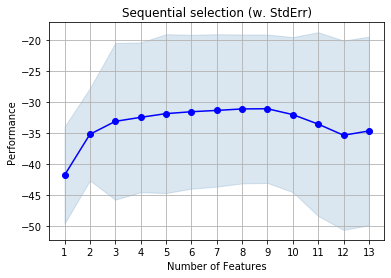

In [24]:
fig = plot_sfs(boston_stepwise_selector.get_metric_dict(), kind = 'std_err')
plt.title('Sequential selection (w. StdErr)')
plt.grid()
plt.show()

To get the best subset of feature at each step, we use `stepwise_selector.get_metric_dict()` which has information about accuracy and a list of the final features **for every step** of step-wise selection. So for example, if we want to know what results look like at step 4, we run `stepwise_selector.get_metric_dict()[4]` (this object is indexed starting at 1). Report accuracy and the the names of the features that at step 4.

In [25]:
boston_stepwise_selector.get_metric_dict()[4]

{'feature_idx': (5, 7, 10, 12),
 'cv_scores': array([ -10.00656532,   -9.40985165,  -13.07520811,  -42.89725103,
         -28.49606301,  -22.10842294,  -11.28626779, -134.73232425,
         -41.95064227,  -11.17580262]),
 'avg_score': -32.5138398991043,
 'feature_names': ('5', '7', '10', '12'),
 'ci_bound': 26.875595344459345,
 'std_dev': 36.185709863761566,
 'std_err': 12.06190328792052}

In [26]:
boston_stepwise_selector.get_metric_dict()

{1: {'feature_idx': (12,),
  'cv_scores': array([-20.92652689, -22.32425963, -18.96963162, -78.46555526,
         -52.84885783, -76.09931615, -37.9345122 , -66.75904048,
         -28.46985684, -15.49202382]),
  'avg_score': -41.828958072164035,
  'feature_names': ('12',),
  'ci_bound': 17.397256205969036,
  'std_dev': 23.423930053497575,
  'std_err': 7.807976684499192},
 2: {'feature_idx': (10, 12),
  'cv_scores': array([-13.48639367, -20.74514134, -16.4783564 , -66.24955762,
         -48.79957418, -50.36923819, -28.14113511, -76.28851481,
         -22.40887643,  -9.46615994]),
  'avg_score': -35.24329476929435,
  'feature_names': ('10', '12'),
  'ci_bound': 16.564282307733052,
  'std_dev': 22.302401342437122,
  'std_err': 7.434133780812375},
 3: {'feature_idx': (5, 10, 12),
  'cv_scores': array([  -8.23806894,   -9.5453911 ,  -11.16464292,  -43.30968796,
          -27.88254143,  -25.69747403,  -15.07866399, -140.66449819,
          -40.14144168,   -9.88008843]),
  'avg_score': -33.160

### End of exercise

## Embedded methods for feature selection

The last thing we cover today are embedded methods for selecting features, which refer to using **regularization** so the algorithm can do feature selection by itself. No wrapping or iterating is required, although if we with to tune the **regularization constant** (also called **shrinkage**) then we have to train many times. The regularization constant is an example of a **hyper-parameter** and **hyper-parameter tuning** is the subject of another lecture. In the below example, the regularization constant is called `alpha` and we show you an example of how tuning `alpha` affects the model.

We will look at two examples of regularizaiton: LASSO and Ridge regression. Both LASSO and Ridge regression are implementations of linear regression where we try to minimize prediction error plus some penalty that depends on the model's parameters (or coefficients) and the shrinkage constant (`alpha` in the code below). LASSO penalizes the model's parameters using the sum of the **absolute values** of the parameters (this is also called **L1-regularization**), while Ridge does so based on the sum of the **squared values** of the parameters (this is also called **L2-regularization**). For reasons we cannot elaborate on here, **LASSO has the by-product that it also does feature selection**, whereas Ridge doesn't. So not all regularization results in feature selection.

In [27]:
from sklearn import linear_model

alpha = 0.25 # increasing alpha can shrink more variable coefficients down to 0
clf = linear_model.Lasso(alpha = alpha)
clf.fit(X, y)

# print(clf.intercept_)
# print(clf.score(X, y))

Lasso(alpha=0.25, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

We can plot the coefficients of the model we trained using a barplot. Notice how some of the coefficients are zero, meaning they were effectively dropped out of the model.

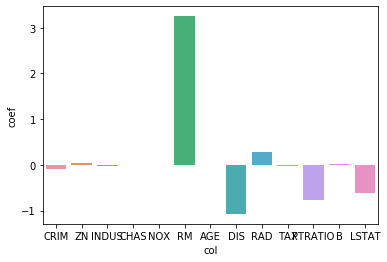

In [28]:
dd = pd.DataFrame({'col': X.columns, 'coef': clf.coef_})
ax = sns.barplot(x = 'col', y = 'coef', data = dd)

We saw the result of one model using `alpha = 0.25`. Now let's see what happens when we train many models with different values for `alpha`. To keep track of it all, we create a `DataFrame` where we store the choice of `alpha` we used and the model's coefficients.

In [29]:
results = pd.DataFrame(columns = ['alpha', 'col', 'coef'])

for alpha in np.arange(0.01, 5, .01):
    clf = linear_model.Lasso(alpha = alpha)
    clf.fit(X, y)
    dd = pd.DataFrame({'col': X.columns, 'coef': clf.coef_})
    dd['alpha'] = alpha
    results = results.append(dd, sort = False)

In [30]:
results.head()

,alpha,col,coef
0,0.01,CRIM,-0.106228
1,0.01,ZN,0.046860
2,0.01,INDUS,0.006474
3,0.01,CHAS,2.504190
4,0.01,NOX,-14.394478


We can plot the value of coefficients against `alpha` to see what happens to the coefficents as we increase the shrinkage constant `alpha`.

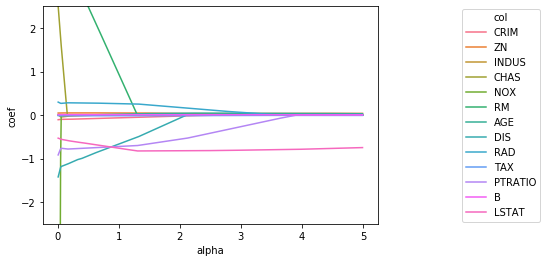

In [31]:
ax = sns.lineplot(x = 'alpha', y = 'coef', hue = 'col', data = results)
ax.set(ylim = (-2.5, 2.5))
ax.legend(loc = 'center right', bbox_to_anchor = (1.5, 0.5), ncol = 1);

As we can see, as `alpha` goes up, the coefficients get smaller and smaller. More importantly,  some coefficients like `NOX` quickly converge to zero (get dropped out of the model), while others like `RM` shrink slowly and slowly. So by increasing `alpha`, we're able to shrink the less important features to zero and end up with fewer features. This is why we say that LASSO regression has the **by-product** of also performing **feature selection**.

Let's train a `LinearRegression` model so we can compare the regularized model (LASSO) to the non-reguralized model (`LinearRegression`).

In [32]:
lm = linear_model.LinearRegression()
lm.fit(X, y)
pred_lm = lm.predict(X) # predictions when using LinearRegression
pred_clf = clf.predict(X) # prediction when using LASSO

np.corrcoef(pred_lm, pred_clf)

array([[1.        , 0.87554611],
       [0.87554611, 1.        ]])

As we can see, the high correlation indicates that our predictions are very close. So dropping a few feature from the model has very little effect on the predictions.

In [33]:
# Ridge Regression
from sklearn import linear_model
alpha = 0.25
clf = linear_model.Ridge(alpha = alpha)
clf.fit(X, y)

# print(clf.coef_)
# print(clf.intercept_)

Ridge(alpha=0.25, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

We can plot the coefficients just like we did with LASSO.

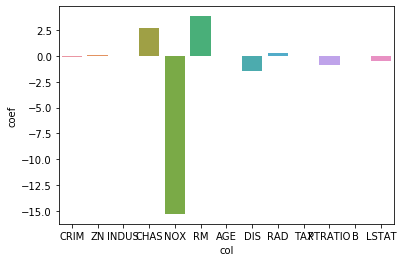

In [34]:
dd = pd.DataFrame({'col': X.columns, 'coef': clf.coef_})
ax = sns.barplot(x = 'col', y = 'coef', data = dd)

It looks like some coefficients are close to zero. But we said eariler that Ridge regression cannot do feature selection like LASSO does. So what happened? What happened is that some coefficients being zero isn't necessarily due to regularization. It could be that those coefficients were just not useful in the first place. To really compare ridge and lasso, we have to see how the coefficients change when we change `alpha`.

In [35]:
results = pd.DataFrame(columns = ['alpha', 'col', 'coef'])

for alpha in np.arange(0.01, 5, .01):
    clf = linear_model.Ridge(alpha = alpha)
    clf.fit(X, y)
    dd = pd.DataFrame({'col': X.columns, 'coef': clf.coef_})
    dd['alpha'] = alpha
    results = results.append(dd, sort = False)

Let's plot the value of coefficients against `alpha` just as we did with LASSO.

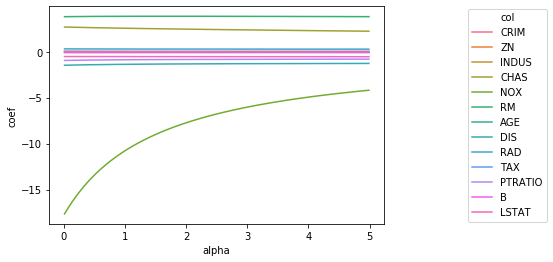

In [36]:
ax = sns.lineplot(x = 'alpha', y = 'coef', hue = 'col', data = results)
ax.legend(loc = 'center right', bbox_to_anchor = (1.5, 0.5), ncol = 1);

Notice that unlike Lasso, Ridge regression's coefficients gradually (asymptotically) shrink as we increase the shrinkage constant `alpha`. So L2-regularization in ridge regression does not result in feature selection like it did with LASSO. So what is it good for? Even though L2-regularization doesn't necessarily reduce the number of features, it is still regularization, which means that it helps us fight against overfitting.